In [1]:
# bids_dir = 'C:\\Users\\Remi\\Documents\\McGurk\\rawdata'
bids_dir = '/data/rawdata'
# output_dir = 'C:\\Users\\Remi\\Documents\\McGurk\\derivatives\\art_repair'
output_dir = '/output/art_repair'

subj_to_run = 0;
run_to_run = 1;

nb_dummy_scans = 250

# time_repetition = 2.56
# num_slices = 42
# time_acquisition = time_repetition - (time_repetition/num_slices);
# slice_order = list(range(0,42,1)) 
ref_slice = 1

In [2]:
from bids.grabbids import BIDSLayout
layout = BIDSLayout(bids_dir)
subject_list = layout.get_subjects()
print(subject_list)
run_list = layout.get_runs(subject=subject_list[subj_to_run])
print(run_list)

input_file = layout.get(type='bold',return_type='file',subject=subject_list[subj_to_run], run=run_list[0:run_to_run])                        
print(input_file)  

anat_file = layout.get(extensions='nii.gz', type='T1w', return_type='file',subject=subject_list[subj_to_run])  
print(anat_file) 

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


['01', '13', '14', '15', '24', '28', '32', '41', '48', '61', '66', '69', '73', '74', '82', '98']
[1, 2, 3, 4, 5, 6, 7, 8]
['/data/rawdata/sub-01/func/sub-01_task-contextmcgurk_run-01_bold.nii.gz']
['/data/rawdata/sub-01/anat/sub-01_T1w.nii.gz']


In [3]:
from nipype import JoinNode, Node, MapNode, Workflow
from nipype.interfaces.io import BIDSDataGrabber, DataSink
from nipype.algorithms.misc import Gunzip
import nipype.interfaces.spm as spm
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl.utils import Split, Merge
from nipype.interfaces.utility import IdentityInterface, Function
from os.path import join as opj


In [4]:
def GetMetadata(layout, input_file):
    import nibabel as nib
    img = nib.load(input_file)
    time_repetition = layout.get_metadata(input_file)["RepetitionTime"]
    slice_timing = layout.get_metadata(input_file)["SliceTiming"]
    num_slices = img.shape[2]
    slice_order = list(range(0,num_slices,1))
    time_acquisition = time_repetition - (time_repetition/num_slices);
    ouput_file = input_file
    return ouput_file, time_repetition, num_slices, slice_order, time_acquisition

# ouput_file, time_repetition, num_slices, slice_order, time_acquisition = GetMetadata(layout, input_file[0])
# print(time_repetition)
# print(type(time_repetition))
# print(int(num_slices))
# print(type(num_slices))
# print(slice_order)
# print(type(slice_order))
# print(time_acquisition)
# print(type(time_acquisition))

In [5]:
# just to get the metadata of a bold run
get_metadata = MapNode(Function(function=GetMetadata, 
                input_names=["layout", "input_file"],
                output_names=['ouput_file', 'time_repetition', 'num_slices', 'slice_order', 'time_acquisition']), 
                name="get_metadata", 
                iterfield="input_file")    
    
# extractROI - skip dummy scans
remove_dummy = MapNode(ExtractROI(t_min=nb_dummy_scans, t_size=-1, output_type='NIFTI'),
                name='remove_dummy', 
                iterfield='in_file')

# split 4D into 3D
split_to_3D = MapNode(Split(dimension='t', output_type='NIFTI'),
                name='split_to_3D', 
                iterfield='in_file')

# merge 3D into 4D
merge_to_4D = MapNode(Merge(dimension='t', output_type='NIFTI'),
                name='merge_to_4D', 
                iterfield='in_files')

# realign and unwarp 
# realign_unwarp =  JoinNode(spm.RealignUnwarp(), 
#                            joinsource='merge_to_4D',
#                            joinfield=['in_files'],
#                            name="realign_unwarp")
# realign_unwarp = Node(spm.RealignUnwarp(), 
#                     name="realign_unwarp")
# realign_unwarp.inputs.register_to_mean = False

# realign
# realign =  JoinNode(spm.Realign(), 
#                            joinsource='merge_to_4D',
#                            joinfield=['in_files'],
#                            name="realign_unwarp")
realign = Node(spm.Realign(), 
                    name="realign")
realign.inputs.register_to_mean = False


# slice timing
slice_timing = MapNode(spm.SliceTiming(), 
                name='slice_timing',
                iterfield=['in_files', 'num_slices', 'time_repetition', 'time_acquisition', 'slice_order'] )
# slice_timing.inputs.num_slices = num_slices
# slice_timing.inputs.time_repetition = time_repetition
# slice_timing.inputs.time_acquisition = time_acquisition
# slice_timing.inputs.slice_order = slice_order
slice_timing.inputs.ref_slice = ref_slice

# normalize_func
normalize_func = MapNode(spm.Normalize(),
                name='normalize_func',
                iterfield=['apply_to_files', 'parameter_file'])
normalize_func.inputs.jobtype = "write"

In [6]:
unzip_anat = MapNode(Gunzip(), 
                name='unzip_anat',
                iterfield=['in_file'])

coreg_anat_to_EPI = MapNode(spm.utils.CalcCoregAffine(),
                name='coreg_anat_to_EPI',
                iterfield=['target', 'moving'])

apply_coreg_to_anat = MapNode(spm.utils.ApplyTransform(),
                name='apply_coreg_to_anat',
                iterfield=['in_file', 'mat'])

segment_anat = MapNode(spm.NewSegment(),
                name='segment_anat',
                iterfield=['channel_files'])

normalize_anat = MapNode(spm.Normalize(),
                name='normalize_anat',
                iterfield=['apply_to_files', 'parameter_file'])
# normalize_anat = MapNode(spm.Normalize(),
#                 name='normalize_anat',
#                 iterfield=['parameter_file'])
normalize_anat.inputs.jobtype = "write"

In [7]:
# Create DataSink object
sinker = Node(DataSink(), 
                name='sinker')
sinker.inputs.base_directory = output_dir

# Name of the output folder
# sinker.inputs.base_directory = opj(output_dir, 'sub-' + subject_list[subj_to_run], 'func')

In [8]:
wf = Workflow(name='preprocessing', base_dir=output_dir)

In [9]:
# functional workflow connect nodes with each other
wf.connect([(get_metadata, remove_dummy, [('ouput_file', 'in_file')])])

wf.connect([(remove_dummy, split_to_3D, [('roi_file', 'in_file')])])

wf.connect([(split_to_3D, merge_to_4D, [('out_files', 'in_files')])])

wf.connect([(merge_to_4D, realign, [('merged_file', 'in_files')])])

wf.connect([(realign, slice_timing, [('realigned_files', 'in_files')])])

wf.connect([(get_metadata, slice_timing, [('num_slices', 'num_slices')])])
wf.connect([(get_metadata, slice_timing, [('time_repetition', 'time_repetition')])])
wf.connect([(get_metadata, slice_timing, [('time_acquisition', 'time_acquisition')])])
wf.connect([(get_metadata, slice_timing, [('slice_order', 'slice_order')])])

wf.connect([(segment_anat, normalize_func, [('transformation_mat', 'parameter_file')])])
wf.connect([(slice_timing, normalize_func, [('timecorrected_files', 'apply_to_files')])])

In [10]:
# anat workflow connect nodes with each other
wf.connect([(unzip_anat, coreg_anat_to_EPI, [('out_file', 'moving')])])
wf.connect([(realign, coreg_anat_to_EPI, [('mean_image', 'target')])])

wf.connect([(coreg_anat_to_EPI, apply_coreg_to_anat, [('mat', 'mat')])])
wf.connect([(unzip_anat, apply_coreg_to_anat, [('out_file', 'in_file')])])

wf.connect([(apply_coreg_to_anat, segment_anat, [('out_file', 'channel_files')])])

wf.connect([(segment_anat, normalize_anat, [('transformation_mat', 'parameter_file')])])
wf.connect([(segment_anat, normalize_anat, [('bias_corrected_images', 'apply_to_files')])])

In [11]:
# Connect DataSink with the relevant nodes
wf.connect([ (realign, sinker, [('mean_image', 'sub-01.mean')]),
             (apply_coreg_to_anat, sinker, [('out_file', 'sub-01.anat')]),
             (normalize_anat, sinker, [('normalized_source', 'sub-01.norm_anat')])  ])


In [12]:
graph_name = opj(wf.base_dir, wf.name, 'workflow_graph.png')
detailed_graph_name = opj(wf.base_dir, wf.name, 'workflow_graph_detailed.png')
graph_type = 'orig'

wf.write_graph(graph2use=graph_type, dotfilename=graph_name)
from IPython.display import Image
# Image(filename=graph_name)
Image(filename=detailed_graph_name)

OSError: No command "dot" found on host db6d0357befe. Please check that the corresponding package is installed.

In [13]:

normalize_anat.help()


use spm_normalise for warping an image to a template

http://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=203

Examples
--------
>>> import nipype.interfaces.spm as spm
>>> norm = spm.Normalize()
>>> norm.inputs.source = 'functional.nii'
>>> norm.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	parameter_file: (a file name)
		normalization parameter file*_sn.mat
		mutually_exclusive: source, template
	source: (a list of items which are an existing, uncompressed file
		 (valid extensions: [.nii, .img, .hdr]))
		file to normalize to template
		mutually_exclusive: parameter_file
	template: (an existing file name)
		template file to normalize to
		mutually_exclusive: parameter_file

	[Optional]
	DCT_period_cutoff: (a float)
		Cutoff of for DCT bases
	affine_regularization_type: ('mni' or 'size' or 'none')
		mni, size, none
	apply_to_files: (a list of items which are an existing file name or a
		 list of items which are an existing file name)
		files to apply transformation to
	jobtype: ('e

In [14]:
get_metadata.inputs.layout = layout
get_metadata.inputs.input_file = input_file
unzip_anat.inputs.in_file = anat_file
res = wf.run()



181112-11:03:24,787 nipype.workflow INFO:
	 Workflow preprocessing settings: ['check', 'execution', 'logging', 'monitoring']
181112-11:03:25,305 nipype.workflow INFO:
	 Running serially.
181112-11:03:25,329 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.unzip_anat" in "/output/art_repair/preprocessing/unzip_anat".
181112-11:03:25,483 nipype.workflow INFO:
	 [Node] Setting-up "_unzip_anat0" in "/output/art_repair/preprocessing/unzip_anat/mapflow/_unzip_anat0".
181112-11:03:25,599 nipype.workflow INFO:
	 [Node] Running "_unzip_anat0" ("nipype.algorithms.misc.Gunzip")
181112-11:03:28,317 nipype.workflow INFO:
	 [Node] Finished "_unzip_anat0".
181112-11:03:28,430 nipype.workflow INFO:
	 [Node] Finished "preprocessing.unzip_anat".
181112-11:03:28,455 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.get_metadata" in "/output/art_repair/preprocessing/get_metadata".
181112-11:03:31,195 nipype.workflow INFO:
	 [Node] Setting-up "_get_metadata0" in "/output/art_repair/preproces

181112-11:04:03,283 nipype.workflow INFO:
	 [Node] Finished "_merge_to_4D0".
181112-11:04:03,359 nipype.workflow INFO:
	 [Node] Finished "preprocessing.merge_to_4D".
181112-11:04:03,375 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.realign" in "/output/art_repair/preprocessing/realign".
181112-11:04:04,659 nipype.workflow INFO:
	 [Node] Running "realign" ("nipype.interfaces.spm.preprocess.Realign")
181112-11:04:04,767 nipype.workflow WARNING:
	 [Node] Error on "preprocessing.realign" (/output/art_repair/preprocessing/realign)
181112-11:04:04,819 nipype.workflow ERROR:
	 Node realign failed to run on host db6d0357befe.
181112-11:04:04,847 nipype.workflow ERROR:
	 Saving crash info to /code/crash-20181112-110404-neuro-realign-06e764bd-bece-44c0-8b0d-954354a05b95.pklz
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/linear.py", line 44, in run
    node.run(updatehash=updatehash)
  File "/opt/minicond

RuntimeError: Workflow did not execute cleanly. Check log for details

In [26]:
import nibabel as nib
mean_img = opj(output_dir, 'sub-01', 'mean', 'meanvol0000_merged.nii')
anat_img = opj(output_dir, 'sub-01', 'anat', 'sub-01_T1w_trans.nii')
img = nib.load(anat_img)
img.shape

(176, 240, 256)

Populating the interactive namespace from numpy and matplotlib


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


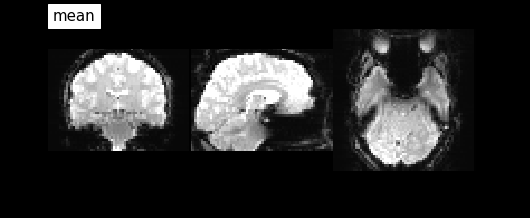

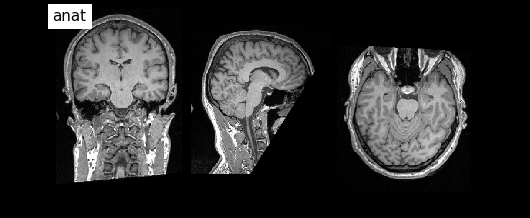

In [27]:
from nilearn.plotting import plot_anat
%pylab inline
%matplotlib inline

mean_img = opj(output_dir, 'sub-01', 'mean', 'meanvol0000_merged.nii')
plot_anat(mean_img, title='mean', cut_coords=(10,10,10),
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);
anat_img = opj(output_dir, 'sub-01', 'anat', 'sub-01_T1w_trans.nii')
plot_anat(anat_img, title='anat', cut_coords=(10,10,10),
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);